here i will be mirroring what i have done wiht NOrmal sample to ER_positive sample

# Logs

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#Paths
base = "/triumvirate/home/alexarol/breast_cancer_analysis"
er_csv = f"{base}/results/recode_outputs/er_positive/ER_Positive_RECODE_sig_genes_cellsxgenes_forWGCNA.csv"
sig_genes_path = f"{base}/results/recode_outputs/er_positive/ER_Positive_RECODE_sig_genes_atleast2.txt"

# Helper functions

In [3]:
def add_mito_qc(adata: sc.AnnData) -> sc.AnnData:
    """Flag mitochondrial genes and compute QC metrics."""
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt"],
        percent_top=None,
        log1p=False,
    
        inplace=True,
    )
    return adata

In [4]:
def summarize_qc(adata, sample_name="sample"):
    """Print QC summary: median, IQR, whiskers for violin metrics."""
    obs = adata.obs
    metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    print(f"QC summary for {sample_name}")
    print("-" * 60)
    for m in metrics:
        s = obs[m]
        desc = s.describe()
        q1, q3 = desc["25%"], desc["75%"]
        iqr = q3 - q1
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr
        print(
            f"{m}: median={desc['50%']:.1f}, IQR=[{q1:.1f}, {q3:.1f}], "
            f"whiskers≈[{lower_whisker:.1f}, {upper_whisker:.1f}], "
            f"min={desc['min']:.1f}, max={desc['max']:.1f}"
        )
    print()

In [ ]:
def suggest_qc_thresholds(adata, fixed_min_genes=200, max_mt_cap=20.0):
    """Suggest data-driven QC thresholds from violin distributions."""
    obs = adata.obs
    
    def whiskers(x):
        desc = x.describe()
        q1, q3 = desc["25%"], desc["75%"]
        iqr = q3 - q1
        return q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    low_w_genes, high_w_genes = whiskers(obs["n_genes_by_counts"])
    min_genes = max(fixed_min_genes, low_w_genes, 0)
    max_genes = high_w_genes
    
    _, high_w_counts = whiskers(obs["total_counts"])
    max_counts = high_w_counts
    
    _, high_w_mt = whiskers(obs["pct_counts_mt"])
    max_pct_mt = min(high_w_mt, max_mt_cap)
    
    thresholds = {
        "min_genes": float(min_genes),
        "max_genes": float(max_genes),
        "max_counts": float(max_counts),
        "max_pct_mt": float(max_pct_mt),
    }
    
    print("Suggested QC thresholds (from violins):")
    for k, v in thresholds.items():
        print(f"  {k}: {v:.2f}")
    print()
    
    return thresholds

: 

# Loading initial data

In [ ]:
#takes 3-4 minuntes
#in normal sample notebook i capped the sample to 10000 cells after filtering, i will implement the same here 
sig_genes = pd.read_csv(sig_genes_path)["gene"].tolist()

#Read header to get columns
all_cols = pd.read_csv(er_csv, nrows=0).columns.tolist()
cell_col = all_cols[0]
expr_cols = all_cols[1:]

#Intersect with sig genes
genes = pd.Index(sig_genes).intersection(expr_cols)

#Cap at 10000 for initial QC/visualization
if len(genes) > 10000:
    genes = genes[:10000]

usecols = [cell_col] + genes.tolist()

print(f"Loading ER_positive data with {len(genes)} genes for QC...")
df = pd.read_csv(er_csv, usecols=usecols, dtype={cell_col: str})

expr = df.iloc[:, 1:]
expr.index = df.iloc[:, 0].astype(str)

adata_er = sc.AnnData(X=expr.values)
adata_er.obs_names = expr.index
adata_er.var_names = expr.columns

print(f"Initial shape: {adata_er.shape}")

Loading ER_positive data with 10000 genes for QC...


# FLAGing MITOCHONDRIAL AND RIBOSOMAL GENES

In [ ]:
#Mitochondrial
adata_er = add_mito_qc(adata_er)

#Ribosomal
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_symbols = ribo_genes[0].values
adata_er.var["ribo"] = adata_er.var_names.isin(ribo_symbols)

#Compute QC metrics
sc.pp.calculate_qc_metrics(
    adata_er,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True,
)

print(adata_er)

AnnData object with n_obs × n_vars = 91908 × 10000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'


In [ ]:
adata_er
adata_er.obs.head()
adata_er.var.head()

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ribo
A1BG,False,21384,0.350992,76.733255,32259,False
A1BG-AS1,False,1874,0.021511,97.961004,1977,False
A2M,False,1686,0.035176,98.165557,3233,False
A2ML1,False,146,0.001861,99.841145,171,False
A4GALT,False,2710,0.032184,97.051399,2958,False


In [ ]:
adata_er.var.sort_values("n_cells_by_counts").head()
adata_er.var.sort_values("n_cells_by_counts", ascending=False).head()

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ribo
MT-CO1,True,91021,92.651684,0.965096,8515431,False
MT-CO3,True,90759,87.849991,1.250163,8074117,False
MT-CO2,True,90723,91.679930,1.289333,8426119,False
FTH1,False,90279,59.851199,1.772425,5500804,False
MALAT1,False,90249,244.560571,1.805066,22477073,False


# Filtering genes (min_cells=3)

In [ ]:
#had to chunk
print(f"Genes before filtering: {adata_er.n_vars}")

gene_counts = np.zeros(adata_er.n_vars, dtype=np.int64)

chunksize = 2000
n_chunks = int(np.ceil(adata_er.n_obs / chunksize))

print(f"Counting gene presence across {adata_er.n_obs} cells in {n_chunks} chunks")
for i in range(n_chunks):
    start = i * chunksize
    end = min((i + 1) * chunksize, adata_er.n_obs)
    
    chunk = adata_er.X[start:end, :]
    
    #handle dense vs sparse
    if hasattr(chunk, "toarray"):  #sparse matrix
        chunk = chunk.toarray()
    
    #(cells × genes) → count how many cells have expression > 0 per gene
    gene_counts += (chunk > 0).sum(axis=0)
    
    if (i + 1) % 10 == 0 or i == n_chunks - 1:
        print(f"  Processed chunk {i+1}/{n_chunks}")

#keep genes expressed in at least 3 cells
genes_keep_mask = gene_counts >= 3
print(f"Genes passing min_cells=3: {genes_keep_mask.sum()} / {adata_er.n_vars}")

adata_er = adata_er[:, genes_keep_mask]
print(f"Genes after filtering: {adata_er.n_vars}")

Genes before filtering: 10000
Counting gene presence across 91908 cells in 46 chunks
  Processed chunk 10/46
  Processed chunk 20/46
  Processed chunk 30/46
  Processed chunk 40/46
  Processed chunk 46/46
Genes passing min_cells=3: 9999 / 10000
Genes after filtering: 9999


# QC VIOLIN PLOTS

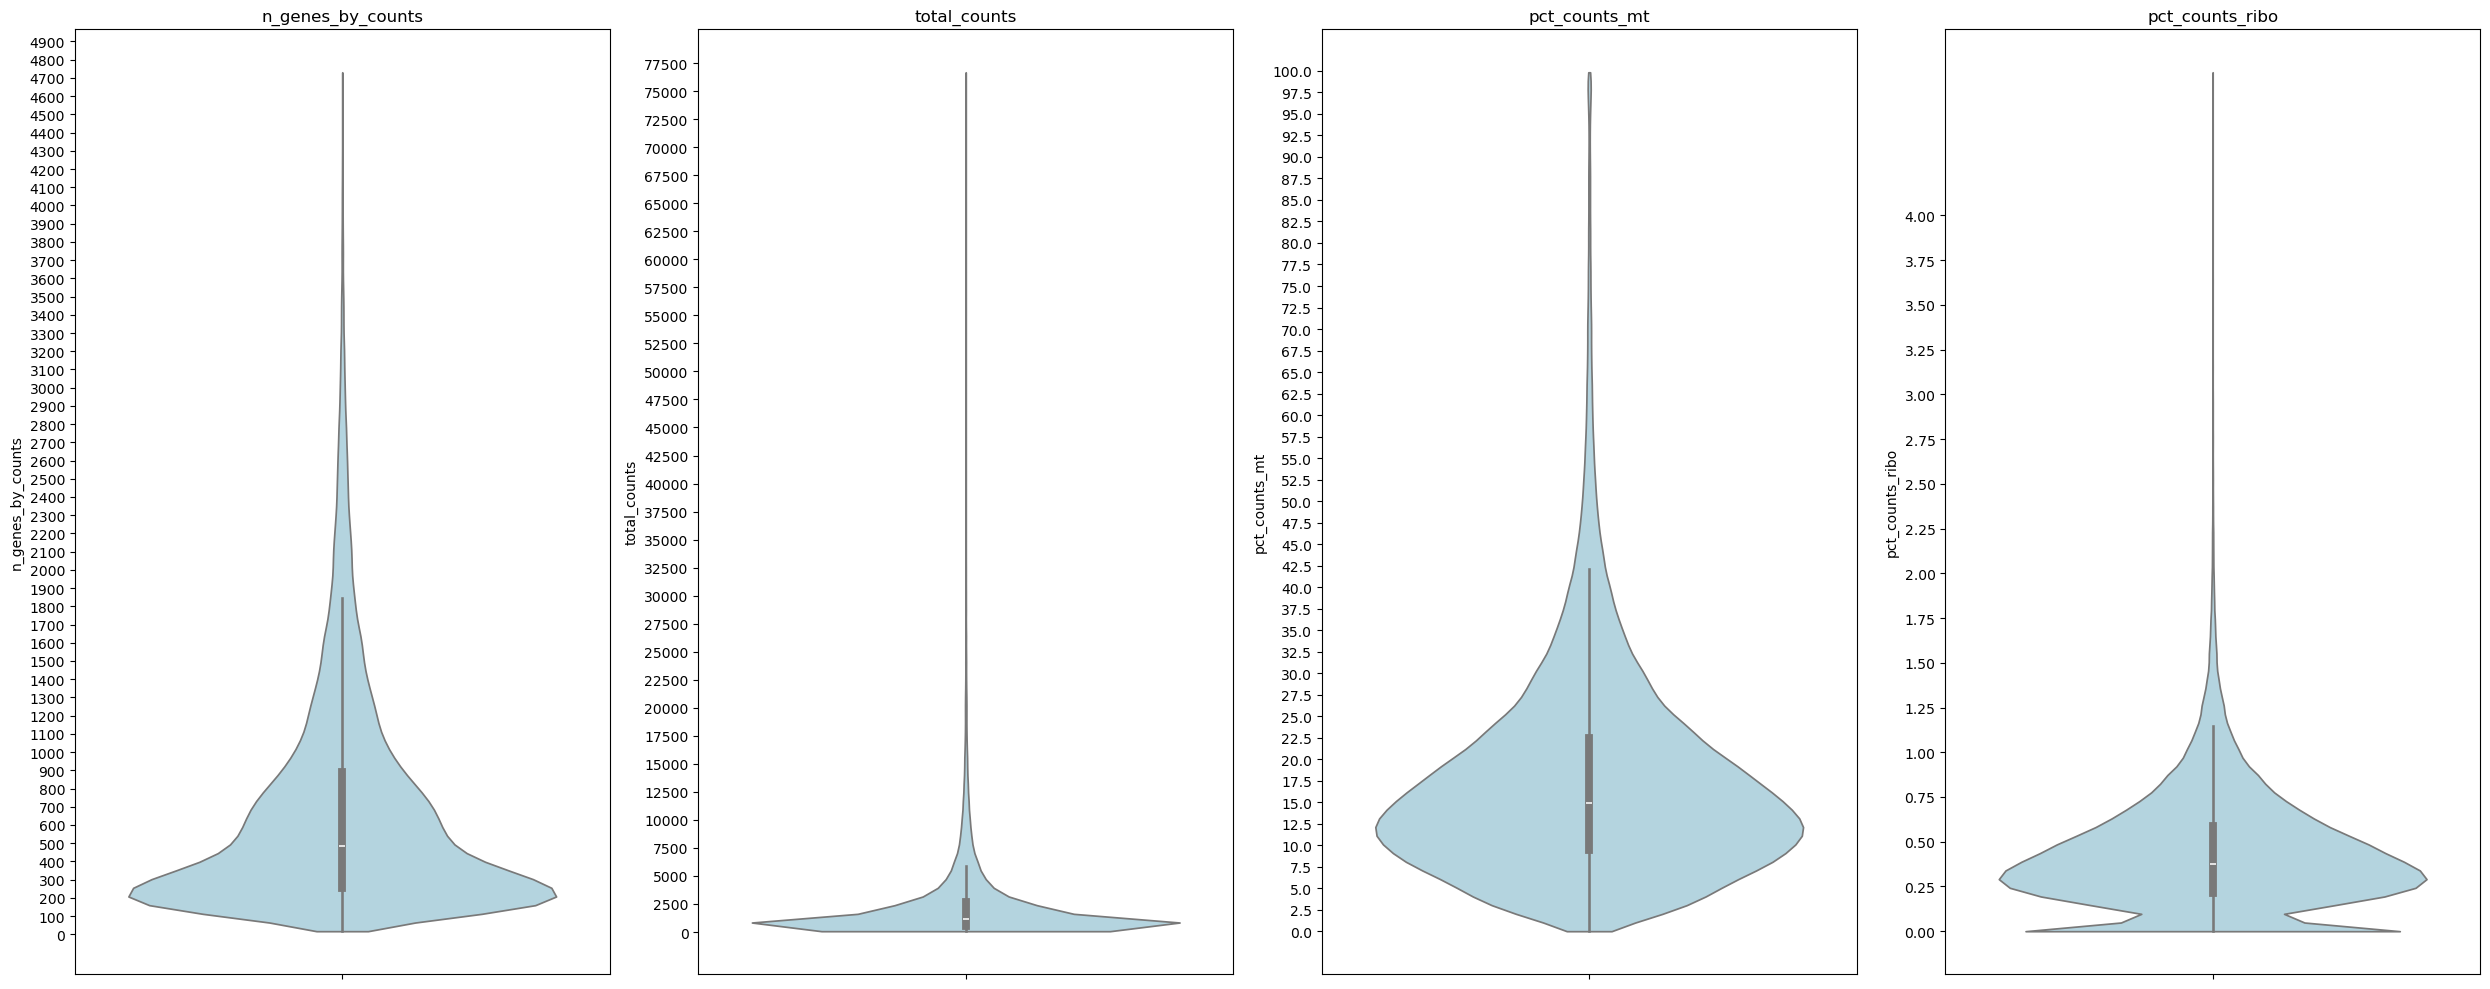

In [ ]:
metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

fig, axes = plt.subplots(1, 4, figsize=(25, 10))

for i, m in enumerate(metrics):
    sns.violinplot(
        y=adata_er.obs[m],
        ax=axes[i],
        inner="box",
        cut=0,
        color="lightblue",
    )
    axes[i].set_title(m)

#Custom y-ticks
axes[0].set_yticks(np.arange(0, 5000, 100))
axes[1].set_yticks(np.arange(0, 80000, 2500))
axes[2].set_yticks(np.arange(0, 101, 2.5))
axes[3].set_yticks(np.arange(0, 4.1, 0.25))

plt.tight_layout()
plt.show()

# Summarizing QC and suggesting treshholds

In [ ]:
summarize_qc(adata_er, sample_name="ER_positive")
thr_er = suggest_qc_thresholds(adata_er)

#Override max_pct_mt to None (no mito filtering, cancer-specific reasoning)
thr_er["max_pct_mt"] = None

QC summary for ER_positive
------------------------------------------------------------
n_genes_by_counts: median=483.0, IQR=[254.0, 891.0], whiskers≈[-701.5, 1846.5], min=17.0, max=4731.0
total_counts: median=1158.0, IQR=[515.0, 2664.0], whiskers≈[-2708.5, 5887.5], min=74.0, max=76679.0
pct_counts_mt: median=14.9, IQR=[9.4, 22.5], whiskers≈[-10.2, 42.1], min=0.0, max=99.8
pct_counts_ribo: median=0.4, IQR=[0.2, 0.6], whiskers≈[-0.3, 1.1], min=0.0, max=4.8

Suggested QC thresholds (from violins):
  min_genes: 200.00
  max_genes: 1846.50
  max_counts: 5887.50
  max_pct_mt: 20.00



# Applying QC filters (n_genes and total_counts only)

In [ ]:
obs = adata_er.obs
mask = (
    (obs["n_genes_by_counts"] >= thr_er["min_genes"]) &
    (obs["n_genes_by_counts"] <= thr_er["max_genes"]) &
    (obs["total_counts"] <= thr_er["max_counts"])
)

print(f"Cells before QC: {adata_er.n_obs}")
print(f"Cells after QC: {mask.sum()}")

adata_er = adata_er[mask]
print(f"{adata_er.n_obs} cells remain after QC")

Cells before QC: 91908
Cells after QC: 68082
68082 cells remain after QC


# POST-QC VIOLIN PLOTS

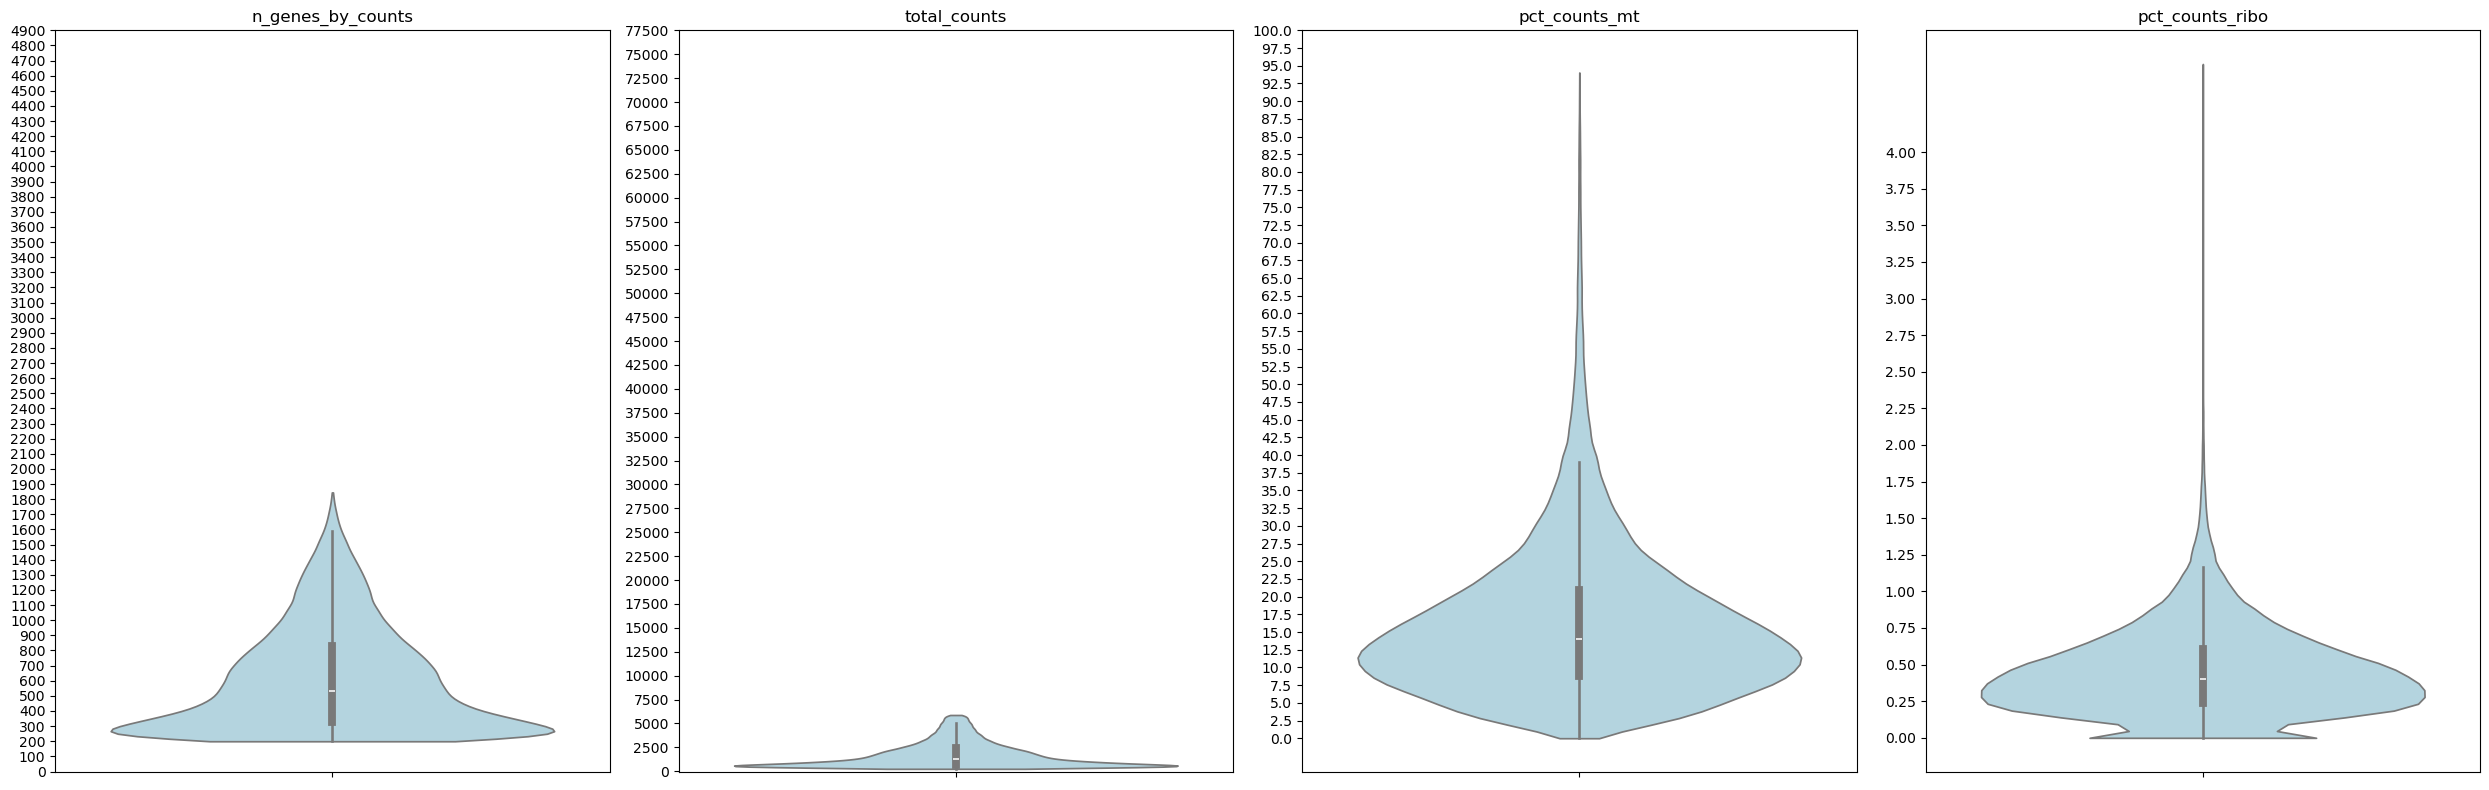

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(25, 8))

for i, m in enumerate(metrics):
    sns.violinplot(
        y=adata_er.obs[m],
        ax=axes[i],
        inner="box",
        cut=0,
        color="lightblue",
    )
    axes[i].set_title(m, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

axes[0].set_yticks(np.arange(0, 5000, 100))
axes[1].set_yticks(np.arange(0, 80000, 2500))
axes[2].set_yticks(np.arange(0, 101, 2.5))
axes[3].set_yticks(np.arange(0, 4.1, 0.25))

plt.tight_layout()
plt.show()

# Saving QC-PASSED CELL IDs

In [ ]:
qc_cells = adata_er.obs_names.to_list()
pd.Series(qc_cells).to_csv("ERpositive_QC_cells.txt", index=False, header=False)
print(f"Saved {len(qc_cells)} QC-passed cell IDs to ERpositive_QC_cells.txt")

Saved 68082 QC-passed cell IDs to ERpositive_QC_cells.txt


# Chunked normalization (CP10k + log1p)

In [ ]:
#This creates the full normalized matrix for WGCNA
#Takes  around 10-15 minutes

qc_cells = set(adata_er.obs_names.astype(str).tolist())
genes_keep = adata_er.var_names.astype(str).tolist()

chunk_iter = pd.read_csv(er_csv, index_col=0, chunksize=1000)

out_path = "ERpositive_QC_CP10k_log1p_forWGCNA.csv"
first_chunk = True

print("Starting chunked normalization")
for i, chunk in enumerate(chunk_iter):
    if i % 50 == 0:
        print(f"  Processing chunk {i}")
    
    chunk.index = chunk.index.astype(str)
    
    #Keep only QC-passed cells
    chunk = chunk.loc[chunk.index.intersection(qc_cells)]
    if chunk.empty:
        continue
    
    #Keep only the global gene set
    cols = [g for g in genes_keep if g in chunk.columns]
    chunk = chunk[cols]
    
    #CP10k normalize
    lib_size = chunk.sum(axis=1)
    chunk_norm = chunk.div(lib_size, axis=0) * 1e4
    
    #log1p
    chunk_log = np.log1p(chunk_norm)
    
    #Write/append
    if first_chunk:
        chunk_log.to_csv(out_path)
        first_chunk = False
    else:
        chunk_log.to_csv(out_path, mode="a", header=False)

print(f"Normalized matrix saved to {out_path}")

Starting chunked normalization


/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):


  Processing chunk 0


/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):
/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):
/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):
/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):
/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_

  Processing chunk 50


/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):
/triumvirate/apps/.scratch/alexarol/ipykernel_283069/753320602.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter):


Normalized matrix saved to ERpositive_QC_CP10k_log1p_forWGCNA.csv


# Verifying normalized matrix

In [ ]:
#Checking dimensions
n_cells = 0
n_genes = None

chunk_iter = pd.read_csv(out_path, index_col=0, chunksize=500, low_memory=False)

for ch in chunk_iter:
    n_cells += ch.shape[0]
    if n_genes is None:
        n_genes = ch.shape[1]

print(f"Normalized matrix: {n_cells} cells × {n_genes} genes")

Normalized matrix: 68082 cells × 9999 genes


# Computing HVGs (3000 genes, chunked variance)

In [ ]:
#Takes around 1 minute

file_path = out_path
chunksize = 500

n_genes_hvg = None
gene_sum = None
gene_sq_sum = None
n_cells_hvg = 0

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing per-gene mean and variance")
for ch in chunk_iter:
    ch_values = ch.values.astype(float)
    if n_genes_hvg is None:
        n_genes_hvg = ch_values.shape[1]
        gene_sum = np.zeros(n_genes_hvg, dtype=np.float64)
        gene_sq_sum = np.zeros(n_genes_hvg, dtype=np.float64)
    
    n = ch_values.shape[0]
    n_cells_hvg += n
    gene_sum += ch_values.sum(axis=0)
    gene_sq_sum += (ch_values ** 2).sum(axis=0)

gene_mean = gene_sum / n_cells_hvg
gene_var = gene_sq_sum / n_cells_hvg - gene_mean**2

#Get gene names
chunk_iter = pd.read_csv(file_path, index_col=0, nrows=1)
gene_names = chunk_iter.columns.to_numpy()

hvg_stats = pd.DataFrame({
    "gene": gene_names,
    "mean": gene_mean,
    "var": gene_var
})

#Sort by variance and pick top 3000
hvg_stats_sorted = hvg_stats.sort_values("var", ascending=False)
top_n = 3000
hvg_3000 = hvg_stats_sorted.head(top_n)["gene"].tolist()

print(f"{len(hvg_3000)} HVGs selected")

#Save HVG list
pd.Series(hvg_3000).to_csv("ERpositive_HVG_3000.txt", index=False, header=False)
print("HVG list saved to ERpositive_HVG_3000.txt")

Computing per-gene mean and variance
3000 HVGs selected
HVG list saved to ERpositive_HVG_3000.txt


# Building HVG AnnData for clustering

In [ ]:
#takes around 1 minute
hvg_3000 = pd.read_csv("ERpositive_HVG_3000.txt", header=None)[0].astype(str).tolist()

file_path = out_path
chunksize = 1000

cell_ids = []
rows = []

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Building HVG AnnData")
for ch in chunk_iter:
    ch = ch[hvg_3000]
    cell_ids.extend(ch.index.astype(str).tolist())
    rows.append(ch.values.astype(np.float32))

X = np.vstack(rows)

adata_hvg = sc.AnnData(X=X)
adata_hvg.obs_names = cell_ids
adata_hvg.var_names = hvg_3000

#Bring over obs metadata from adata_er
adata_hvg.obs = adata_er.obs.loc[adata_hvg.obs_names].copy()

print(f"HVG AnnData shape: {adata_hvg.shape}")
print(adata_hvg.obs.head())

Building HVG AnnData
HVG AnnData shape: (68082, 3000)
    n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
8                1640          5655              469       8.293546   
12               1012          3000               11       0.366667   
17               1501          4224              554      13.115530   
20                857          2447              217       8.868002   
23                243           432                1       0.231481   

    total_counts_ribo  pct_counts_ribo  
8                  25         0.442087  
12                 14         0.466667  
17                 12         0.284091  
20                  8         0.326931  
23                  3         0.694444  


/triumvirate/apps/.scratch/alexarol/ipykernel_283069/1742686885.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  subset = pd.read_csv(file_path, index_col=0, nrows=5000)


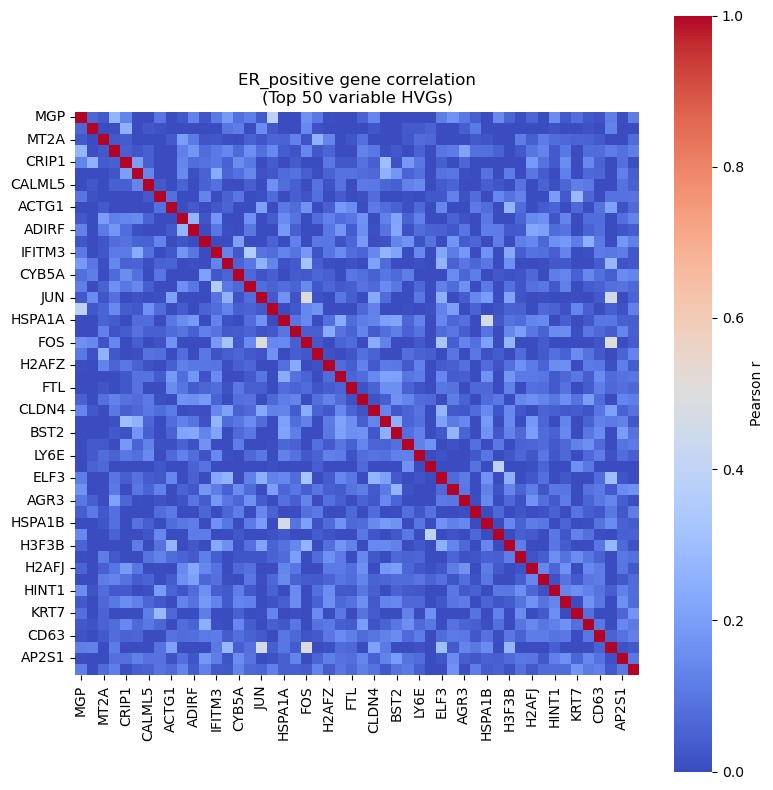

In [ ]:
file_path = "ERpositive_QC_CP10k_log1p_forWGCNA.csv"
hvg_3000 = pd.read_csv("ERpositive_HVG_3000.txt", header=None)[0].astype(str).tolist()

#read a manageable subset of cells to estimate variability (e.g. first 5000)
subset = pd.read_csv(file_path, index_col=0, nrows=5000)
subset = subset[hvg_3000]  #keep HVGs only

#pick top 50 most variable HVGs within this subset
gene_var = subset.var(axis=0)
top_n = 50
top_genes = gene_var.sort_values(ascending=False).head(top_n).index.tolist()

#compute full correlation among these 50 genes across ALL cells (chunked)
chunksize = 2000
corr_data = {g: [] for g in top_genes}

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)
for ch in chunk_iter:
    ch = ch[top_genes]
    corr_data_chunk = ch  # each chunk is cells × 50 genes
    for g in top_genes:
        corr_data[g].extend(corr_data_chunk[g].values.tolist())

corr_df = pd.DataFrame(corr_data)

corr_mat = corr_df.corr(method="pearson")

#plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_mat,
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("ER_positive gene correlation\n(Top 50 variable HVGs)")
plt.tight_layout()
plt.show()

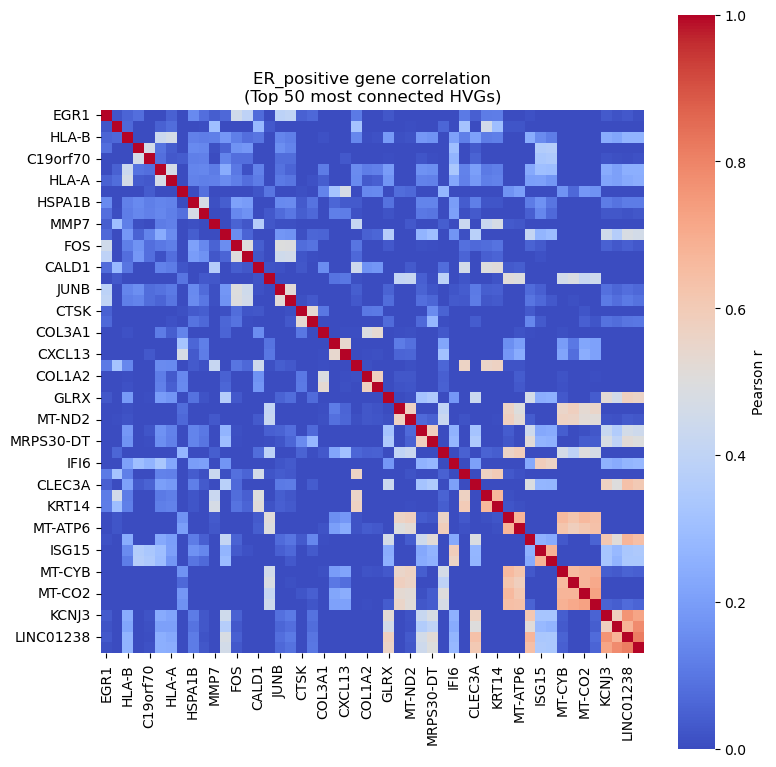

In [ ]:
#corr_matrix (3000×3000) and hvg_3000
corr_matrix = np.load("ERpositive_HVG_correlation_matrix.npy")
hvg_3000 = pd.read_csv("ERpositive_HVG_3000.txt", header=None)[0].astype(str).tolist()

#for each gene, compute max(|r|) to any other gene
max_abs_r = np.max(np.abs(corr_matrix - np.eye(corr_matrix.shape[0])), axis=1)
top_n = 50
top_idx = np.argsort(max_abs_r)[-top_n:]
top_genes = [hvg_3000[i] for i in top_idx]

sub_corr = corr_matrix[np.ix_(top_idx, top_idx)]
corr_df = pd.DataFrame(sub_corr, index=top_genes, columns=top_genes)

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    square=True,
    cbar_kws={"label": "Pearson r"},
)
plt.title("ER_positive gene correlation\n(Top 50 most connected HVGs)")
plt.tight_layout()
plt.show()

# SCALE, PCA, NEIGHBORS, UMAP, LEIDEN

In [ ]:
# Takes around
print("Scaling genes")
sc.pp.scale(adata_hvg, max_value=10)

Scaling genes


In [ ]:
print("Computing PCA")
sc.tl.pca(adata_hvg, svd_solver="arpack")

Computing PCA


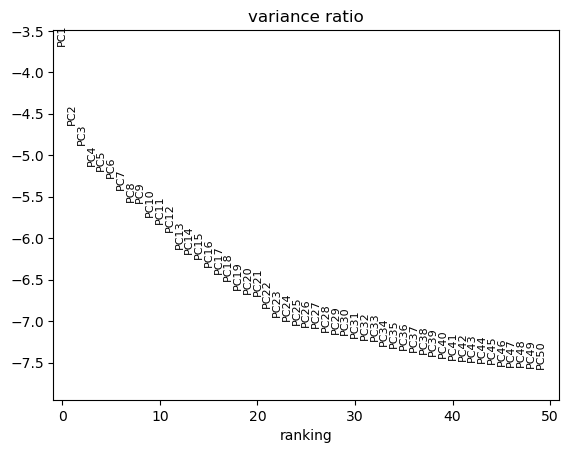

In [ ]:
sc.pl.pca_variance_ratio(adata_hvg, log=True, n_pcs=50)

In [ ]:
print("Building neighbor graph (30 PCs)")
sc.pp.neighbors(adata_hvg, n_pcs=30)

Building neighbor graph (30 PCs)


In [ ]:
#takes aroudn 1 minute
print("Computing UMAP")
sc.tl.umap(adata_hvg)

Computing UMAP


In [ ]:
print("Leiden clustering (resolution=0.5)")
sc.tl.leiden(adata_hvg, resolution=0.5)

Leiden clustering (resolution=0.5)


/triumvirate/apps/.scratch/alexarol/ipykernel_283069/556435756.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=0.5)


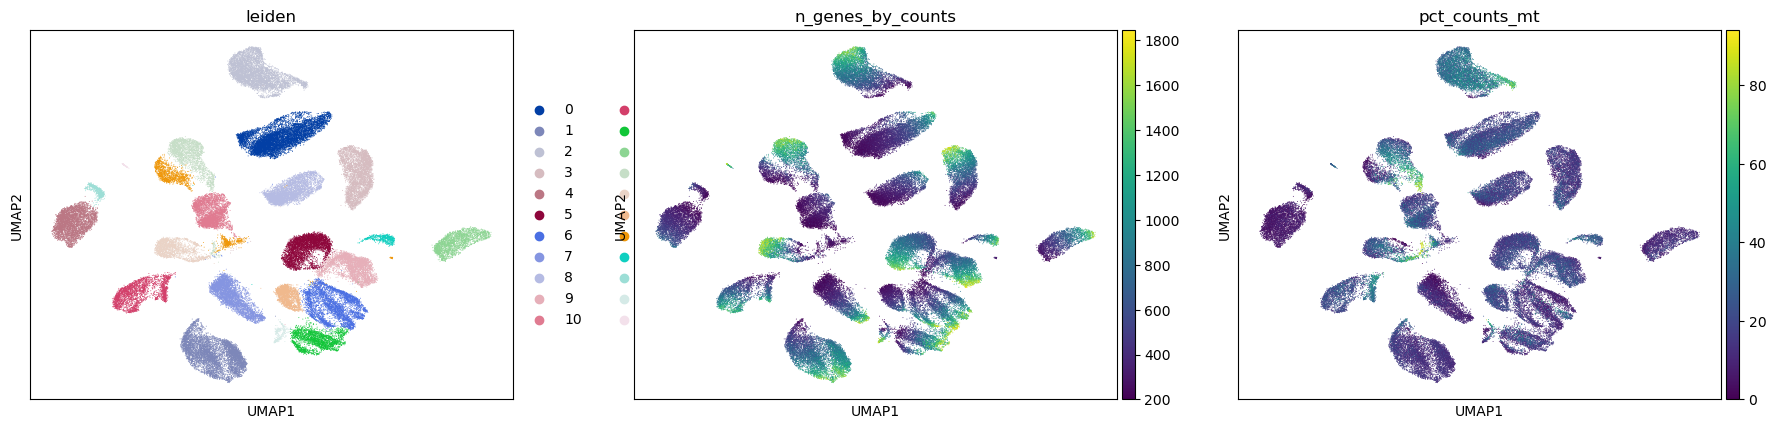

In [ ]:
sc.pl.umap(adata_hvg, color=["leiden", "n_genes_by_counts", "pct_counts_mt"])

- Leiden panel: I have many compact, well‑separated clusters, with no obvious “stringy” artifacts or one giant blob, which indicates the 30‑PC neighbor graph is capturing meaningful structure in ER_positive cells.
- n_genes_by_counts: There is some within‑cluster variation but no single cluster that is purely “low‑genes junk” or “extreme high‑genes” across the whole cluster, so clustering is not trivially driven by library complexity alone.
- pct_counts_mt: A few clusters or subregions show higher mt%, but there is not a single isolated “all‑mt” island; this matches tumor‑like mito distribution and supports the choice to keep mt‑high cells and later flag mt‑rich clusters.

# Flagging HIGH-MT clusters

Global pct_mt summary:
count    68082.000000
mean        16.308150
std         11.119609
min          0.000000
25%          8.802853
50%         13.949329
75%         20.900322
max         94.036087
Name: pct_counts_mt, dtype: float64
Upper whisker ≈ 39.0%
Mean pct_counts_mt per cluster:
leiden
4      4.624505
19     5.070365
7      6.996054
13     9.754106
6     11.341988
1     12.025299
3     13.276581
12    13.746480
8     14.295296
5     15.622131
20    16.161413
17    16.922632
9     17.054555
16    17.058673
10    17.632314
0     18.135769
11    22.516248
15    22.583211
18    23.844844
21    25.334136
2     32.192775
14    34.759799
Name: pct_counts_mt, dtype: float64

High-mt clusters (mean > upper whisker ≈ 39.0%): []


/triumvirate/apps/.scratch/alexarol/ipykernel_283069/1885830169.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_mt = adata_hvg.obs.groupby("leiden")["pct_counts_mt"].mean().sort_values()


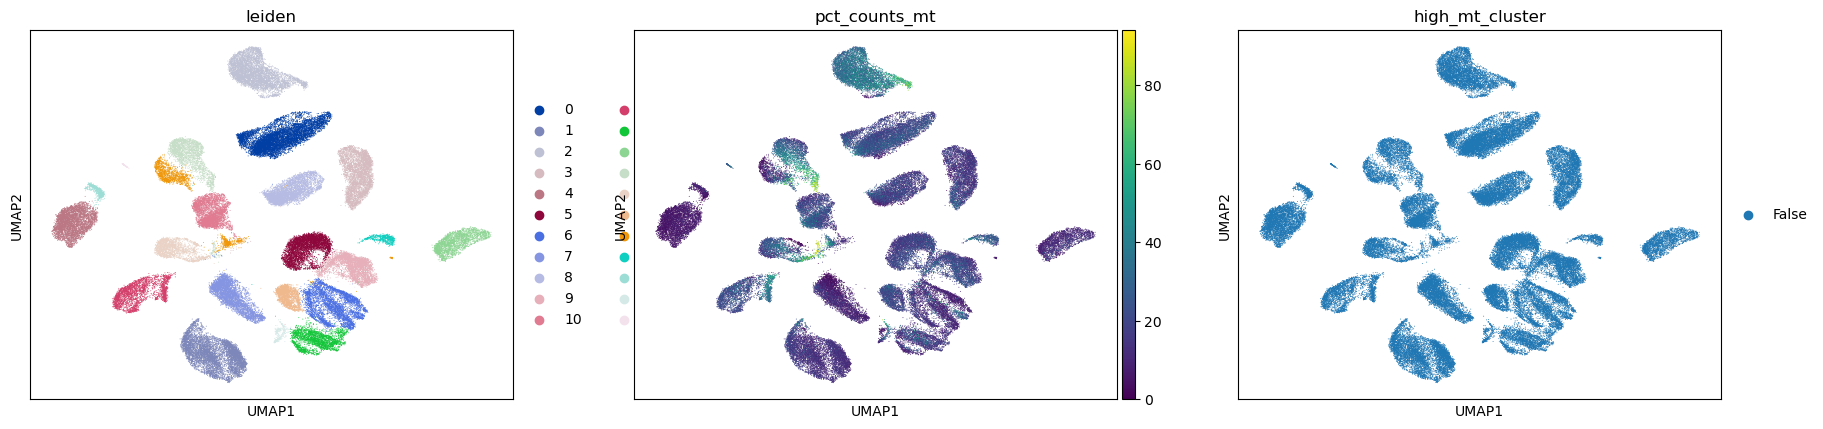

In [ ]:
#Defining high‑mt clusters from the numbers
#global stats
desc = adata_hvg.obs["pct_counts_mt"].describe()
q1, q3 = desc["25%"], desc["75%"]
iqr = q3 - q1
upper_whisker = q3 + 1.5 * iqr

print("Global pct_mt summary:")
print(desc)
print(f"Upper whisker ≈ {upper_whisker:.1f}%")

cluster_mt = adata_hvg.obs.groupby("leiden")["pct_counts_mt"].mean().sort_values()
print("Mean pct_counts_mt per cluster:")
print(cluster_mt)

# flag clusters whose mean is above the upper whisker
high_mt_clusters = cluster_mt[cluster_mt > upper_whisker].index.tolist()
print(f"\nHigh-mt clusters (mean > upper whisker ≈ {upper_whisker:.1f}%): {high_mt_clusters}")

adata_hvg.obs["high_mt_cluster"] = adata_hvg.obs["leiden"].isin(high_mt_clusters)

sc.pl.umap(adata_hvg, color=["leiden", "pct_counts_mt", "high_mt_cluster"])

As for now I would not force a high‑mt flag here; it’s fine that high_mt_cluster is all False for ER_positive.

I can write in the methods that high‑mt clusters were defined per sample using data‑driven mt distributions; ER_positive did not contain any clusters whose mean mt exceeded the outlier threshold, so no clusters were flagged as high‑mt in this sample.

# Saving frozen AnnData

In [ ]:
adata_hvg.write_h5ad("adata_ERpositive_HVG_UMAP_leiden_frozen.h5ad")
print("Saved frozen AnnData to adata_ERpositive_HVG_UMAP_leiden_frozen.h5ad")

Saved frozen AnnData to adata_ERpositive_HVG_UMAP_leiden_frozen.h5ad


# Marker genes per cluster (Top 20)

In [ ]:
print("Computing marker genes per cluster")
sc.tl.rank_genes_groups(adata_hvg, groupby="leiden", method="wilcoxon")

#Extracting top 20 per cluster
n_top = 20
marker_dict = {}

for cluster in adata_hvg.obs["leiden"].cat.categories:
    markers = sc.get.rank_genes_groups_df(adata_hvg, group=cluster).head(n_top)
    marker_dict[cluster] = markers["names"].tolist()
    print(f"Cluster {cluster}: {markers['names'].tolist()[:5]}...")  #show first 5

#Saving markers
import pickle
with open("ERpositive_cluster_markers_top20.pkl", "wb") as f:
    pickle.dump(marker_dict, f)

print("Saved cluster markers to ERpositive_cluster_markers_top20.pkl")

Computing marker genes per cluster


/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnaseq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/triumvirate/home/alexarol/.conda/envs/breast_cancer_scrnase

Cluster 0: ['EEF1D', 'EIF3H', 'IGFBP5', 'EEF2', 'EEF1A1']...
Cluster 1: ['FTH1', 'LINC01238', 'KCNE4', 'MRPS30-DT', 'CST5']...
Cluster 2: ['MT-ND3', 'METRN', 'MT-CO2', 'MT-ATP6', 'MT-CYB']...
Cluster 3: ['COL1A1', 'COL1A2', 'MALAT1', 'FASN', 'CLIC6']...
Cluster 4: ['INSR', 'C19orf70', 'H3F3B', 'IFI27', 'HSPB1']...
Cluster 5: ['FABP3', 'COX6C', 'MT-ND5', 'HEBP1', 'ADIRF']...
Cluster 6: ['MGP', 'GSTP1', 'KRT15', 'AZGP1', 'ITM2B']...
Cluster 7: ['CTTN', 'HNRNPH1', 'CTNNB1', 'HSPA1A', 'KRT8']...
Cluster 8: ['CRIP1', 'MIF', 'CHCHD2', 'AZGP1', 'ATP5MG']...
Cluster 9: ['MT-ND5', 'MGP', 'GSTM3', 'EMP2', 'MT-ND1']...
Cluster 10: ['MT-ND1', 'KRT15', 'COX6C', 'CRIP1', 'KRT19']...
Cluster 11: ['MT-ND2', 'COX6A1', 'ATP5F1E', 'AGR2', 'GSTM3']...
Cluster 12: ['CRYAB', 'ANXA1', 'MGP', 'KRT14', 'KRT17']...
Cluster 13: ['CPB1', 'IGFBP5', 'MRPS21', 'MCL1', 'GATA3']...
Cluster 14: ['CD24', 'MT-ATP6', 'KRT7', 'MT-ND4', 'LMO4']...
Cluster 15: ['CALML5', 'LYPLA1', 'FAM210B', 'HSP90AA1', 'ESF1']...
Cluster 16

# NETWORK ANALYSIS - CHUNKED CORRELATION (3000×3000)

In [ ]:
#This computes Pearson correlation between all HVG pairs
#Takes around 15-30 minutes depending on sample size

file_path = out_path
hvg_3000 = pd.read_csv("ERpositive_HVG_3000.txt", header=None)[0].astype(str).tolist()

chunksize = 1000
gene_sum = None
gene_sq_sum = None
n_cells_corr = 0

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing gene-gene correlation (pass 1: means)")
for ch in chunk_iter:
    ch = ch[hvg_3000]
    ch_values = ch.values.astype(np.float64)
    
    if gene_sum is None:
        n_genes_corr = ch_values.shape[1]
        gene_sum = np.zeros(n_genes_corr, dtype=np.float64)
        gene_sq_sum = np.zeros(n_genes_corr, dtype=np.float64)
    
    n = ch_values.shape[0]
    n_cells_corr += n
    gene_sum += ch_values.sum(axis=0)
    gene_sq_sum += (ch_values ** 2).sum(axis=0)

gene_mean_corr = gene_sum / n_cells_corr
gene_std = np.sqrt(gene_sq_sum / n_cells_corr - gene_mean_corr**2)

print(f"Pass 1 complete: {n_cells_corr} cells processed")

Computing gene-gene correlation (pass 1: means)
Pass 1 complete: 68082 cells processed


In [ ]:
#Pass 2: covariance matrix
cov_matrix = np.zeros((n_genes_corr, n_genes_corr), dtype=np.float64)

chunk_iter = pd.read_csv(file_path, index_col=0, chunksize=chunksize, low_memory=False)

print("Computing gene-gene correlation (pass 2: covariance)")
for i, ch in enumerate(chunk_iter):
    if i % 50 == 0:
        print(f"  Chunk {i}")
    
    ch = ch[hvg_3000]
    ch_values = ch.values.astype(np.float64)
    
    #Center
    ch_centered = ch_values - gene_mean_corr
    
    #Accumulate covariance
    cov_matrix += ch_centered.T @ ch_centered

#Normalize to correlation
cov_matrix /= n_cells_corr
corr_matrix = cov_matrix / np.outer(gene_std, gene_std)

#clip to [-1, 1] for numerical stability
corr_matrix = np.clip(corr_matrix, -1, 1)

print(f"Correlation matrix shape: {corr_matrix.shape}")
print(f"Min correlation: {corr_matrix.min():.3f}")
print(f"Max correlation: {corr_matrix.max():.3f}")

#save correlation matrix
np.save("ERpositive_HVG_correlation_matrix.npy", corr_matrix)
print("Saved correlation matrix to ERpositive_HVG_correlation_matrix.npy")

Computing gene-gene correlation (pass 2: covariance)
  Chunk 0
  Chunk 50
Correlation matrix shape: (3000, 3000)
Min correlation: -0.454
Max correlation: 1.000
Saved correlation matrix to ERpositive_HVG_correlation_matrix.npy


# Building gene co-expression network

In [ ]:
#(threshold |r| >= 0.45)
corr_matrix = np.load("ERpositive_HVG_correlation_matrix.npy")
hvg_3000 = pd.read_csv("ERpositive_HVG_3000.txt", header=None)[0].tolist()

threshold = 0.45

#Building edge list
edges = []
n_genes_net = len(hvg_3000)

print(f"Building network with |r| >= {threshold}")
for i in range(n_genes_net):
    for j in range(i + 1, n_genes_net):
        r = corr_matrix[i, j]
        if abs(r) >= threshold:
            edges.append((hvg_3000[i], hvg_3000[j], {"weight": r}))

print(f"Found {len(edges)} edges")

#Creating network
G = nx.Graph()
G.add_nodes_from(hvg_3000)
G.add_edges_from(edges)

print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

#Saving network
nx.write_graphml(G, "ERpositive_gene_network_r045.graphml")
print("Saved network to ERpositive_gene_network_r045.graphml")

Building network with |r| >= 0.45
Found 96 edges
Network: 3000 nodes, 96 edges
Saved network to ERpositive_gene_network_r045.graphml


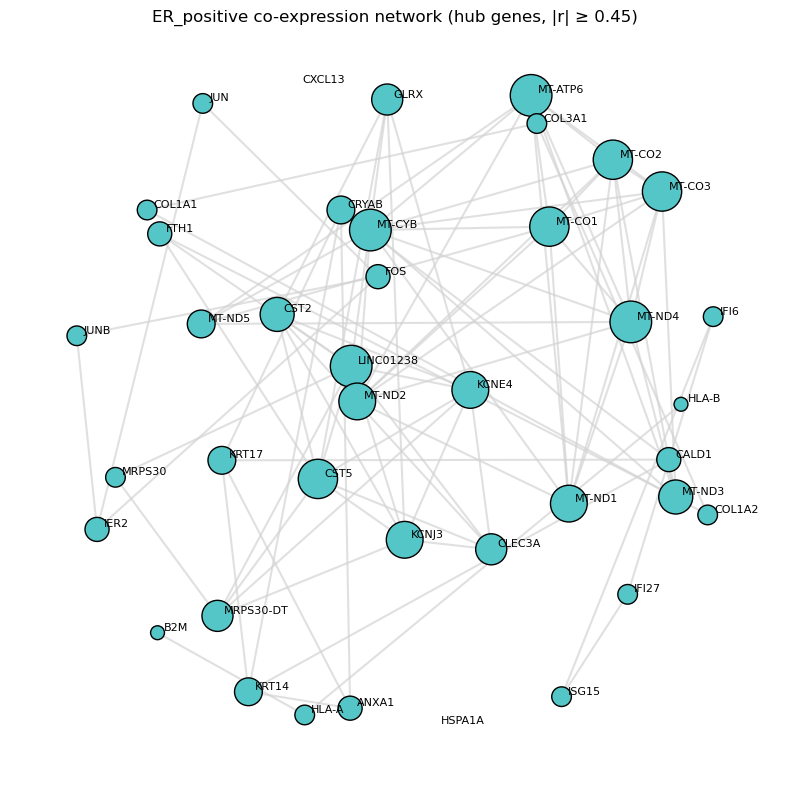

In [ ]:
#pick hub genes: top N by degree (30)
N = 40
degree_dict = dict(G.degree())
top_hubs = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:N]
hub_genes = [g for g, d in top_hubs]

H = G.subgraph(hub_genes).copy()

#layout
pos = nx.spring_layout(H, seed=0, k=1.3)  # tweak k if too tight/loose

#node sizes proportional to degree
deg_H = dict(H.degree())
node_sizes = np.array([deg_H[g] for g in H.nodes()]) * 100  # scale factor

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(H, pos, width=1.5, edge_color="lightgrey", alpha=0.7)
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color="#c2f2a2", edgecolors="black")

for node, (x, y) in pos.items():
    plt.text(
        x + 0.02, y, node,
        fontsize=8,
        ha="left", va="bottom"
    )

plt.title("ER_positive co-expression network (hub genes, |r| ≥ 0.45)")
plt.axis("off")
plt.tight_layout()
plt.show()


# Detecting modules (Louvain)

In [ ]:
print("Detecting modules with Louvain...")
modules = nx.community.louvain_communities(G, seed=42)

print(f"Found {len(modules)} modules")

#Creating gene-to-module mapping
gene_to_module = {}
for module_id, gene_set in enumerate(modules):
    for gene in gene_set:
        gene_to_module[gene] = module_id

#Module sizes
module_sizes = [len(m) for m in modules]
print(f"Module sizes: min={min(module_sizes)}, max={max(module_sizes)}, median={np.median(module_sizes):.0f}")

#Saving modules
with open("ERpositive_gene_modules.pkl", "wb") as f:
    pickle.dump(modules, f)

with open("ERpositive_gene_to_module.pkl", "wb") as f:
    pickle.dump(gene_to_module, f)

print("Saved modules to ERpositive_gene_modules.pkl and ERpositive_gene_to_module.pkl")

Detecting modules with Louvain...
Found 2961 modules
Module sizes: min=1, max=10, median=1
Saved modules to ERpositive_gene_modules.pkl and ERpositive_gene_to_module.pkl


# Largest connected component plot

In [ ]:
corr_matrix = np.load("ERpositive_HVG_correlation_matrix.npy")
hvg_3000 = pd.read_csv("ERpositive_HVG_3000.txt", header=None)[0].tolist()

threshold = 0.45
edges = []
n_genes_net = len(hvg_3000)

print(f"Building network with |r| >= {threshold}")
for i in range(n_genes_net):
    for j in range(i + 1, n_genes_net):
        r = corr_matrix[i, j]
        if abs(r) >= threshold:
            edges.append((hvg_3000[i], hvg_3000[j], {"weight": r}))

print(f"Found {len(edges)} edges")

G_E = nx.Graph()
G_E.add_nodes_from(hvg_3000)
G_E.add_edges_from(edges)

print(f"ER+ network (E): {G_E.number_of_nodes()} nodes, {G_E.number_of_edges()} edges")

# get all connected components
components_E = list(nx.connected_components(G_E))
print(f"Number of connected components in ER+ network: {len(components_E)}")

# largest component by number of nodes
largest_cc_E = max(components_E, key=len)

# induced subgraph
G_E_lcc = G_E.subgraph(largest_cc_E).copy()

print(f"ER+ largest CC: {G_E_lcc.number_of_nodes()} nodes, {G_E_lcc.number_of_edges()} edges")

plt.figure(figsize=(8, 8))

# spring layout for the largest CC
pos_E = nx.spring_layout(G_E_lcc, seed=0, k=1.3)

# node size proportional to degree within the LCC
deg_E_lcc = dict(G_E_lcc.degree())
node_sizes = np.array([deg_E_lcc[g] for g in G_E_lcc.nodes()]) * 20  # adjust scale as needed

nx.draw_networkx_edges(
    G_E_lcc,
    pos_E,
    width=0.5,
    edge_color="lightgrey",
    alpha=0.7,
)

nx.draw_networkx_nodes(
    G_E_lcc,
    pos_E,
    node_size=node_sizes,
    node_color="#ffaf40",  # different color for ER+ if you want
    edgecolors="black",
)

# label only if not too many nodes; otherwise comment this out
for node, (x, y) in pos_E.items():
    plt.text(
        x + 0.01, y,
        node,
        fontsize=6,
        ha="left",
        va="bottom"
    )

plt.title("ER-positive (E) co-expression network – largest connected component (|r| ≥ 0.45)")
plt.axis("off")
plt.tight_layout()
plt.show()

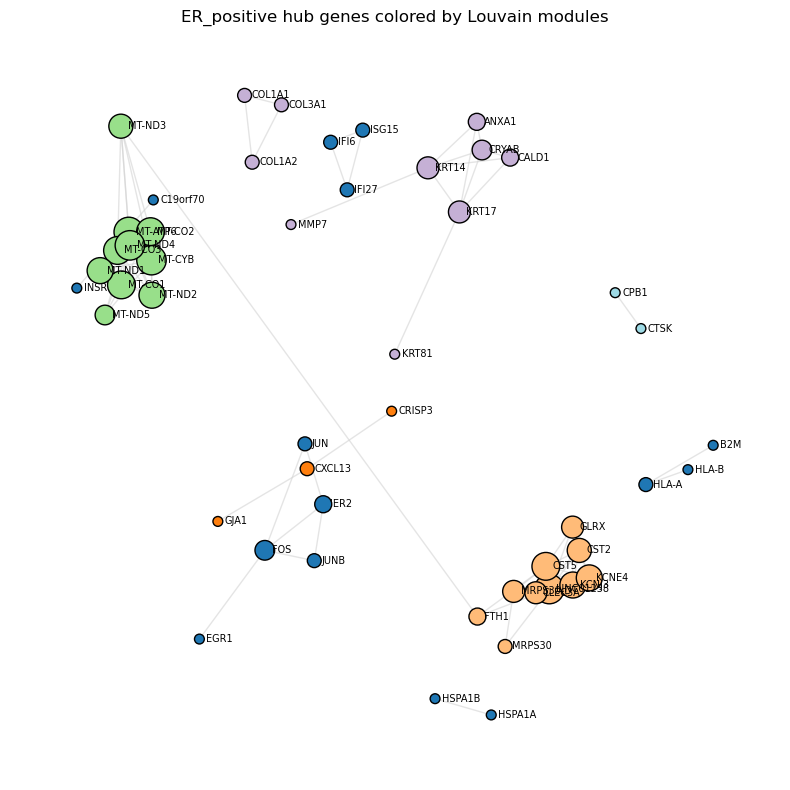

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

#assume: G, modules, gene_to_module already defined

#pick hub genes again (e.g. top 50 by degree)
N = 50
degree_dict = dict(G.degree())
top_hubs = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:N]
hub_genes = [g for g, d in top_hubs]

H = G.subgraph(hub_genes).copy()

#positions (reuse same seed so layout is stable)
pos = nx.spring_layout(H, seed=0, k=0.3)

#node sizes by degree
deg_H = dict(H.degree())
node_sizes = np.array([deg_H[g] for g in H.nodes()]) * 50

#module ID for each node
node_modules = [gene_to_module[g] for g in H.nodes()]

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(H, pos, width=1.0, edge_color="lightgrey", alpha=0.6)

nodes = nx.draw_networkx_nodes(
    H, pos,
    node_size=node_sizes,
    node_color=node_modules,
    cmap="tab20",    # or another qualitative colormap
    edgecolors="black"
)

#labels offset (to keep circles clean)
for node, (x, y) in pos.items():
    plt.text(x + 0.02, y, node, fontsize=7, ha="left", va="center")

plt.title("ER_positive hub genes colored by Louvain modules")
plt.axis("off")
plt.tight_layout()
plt.show()

# HUB GENES PER MODULE (top 10 by degree)

In [ ]:
module_hubs = {}

for module_id, gene_set in enumerate(modules):
    subgraph = G.subgraph(gene_set)
    degrees = dict(subgraph.degree())
    
    #Sort by degree
    sorted_genes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    top_10 = [gene for gene, deg in sorted_genes[:10]]
    
    module_hubs[module_id] = top_10
    print(f"Module {module_id} ({len(gene_set)} genes): {top_10[:5]}...")  # show first 5

#Save hubs
with open("ERpositive_module_hubs_top10.pkl", "wb") as f:
    pickle.dump(module_hubs, f)

print("Saved module hubs to ERpositive_module_hubs_top10.pkl")

Module 0 (1 genes): ['MGP']...
Module 1 (1 genes): ['IGFBP5']...
Module 2 (3 genes): ['ISG15', 'IFI27', 'IFI6']...
Module 3 (1 genes): ['CD24']...
Module 4 (1 genes): ['ADIRF']...
Module 5 (1 genes): ['CRIP1']...
Module 6 (1 genes): ['MT2A']...
Module 7 (1 genes): ['LGALS1']...
Module 8 (1 genes): ['AZGP1']...
Module 9 (1 genes): ['IFITM3']...
Module 10 (3 genes): ['HLA-A', 'HLA-B', 'B2M']...
Module 11 (1 genes): ['ELF3']...
Module 12 (5 genes): ['FOS', 'IER2', 'JUNB', 'JUN', 'EGR1']...
Module 13 (1 genes): ['KRT7']...
Module 14 (1 genes): ['HES1']...
Module 15 (1 genes): ['CXCL14']...
Module 16 (1 genes): ['AGR2']...
Module 17 (2 genes): ['HSPA1B', 'HSPA1A']...
Module 18 (1 genes): ['CRABP2']...
Module 19 (1 genes): ['HSPB1']...
Module 20 (1 genes): ['AGR3']...
Module 21 (1 genes): ['COX6C']...
Module 22 (1 genes): ['DUSP1']...
Module 23 (1 genes): ['BTG2']...
Module 24 (1 genes): ['CST3']...
Module 25 (1 genes): ['EIF3H']...
Module 26 (1 genes): ['IER3']...
Module 27 (1 genes): ['HLA

In [ ]:
print("\n" + "="*60)
print("ER_positive analysis complete!")
print("="*60)
print(f"QC-passed cells: {adata_hvg.n_obs}")
print(f"HVGs: {len(hvg_3000)}")
print(f"Leiden clusters: {len(adata_hvg.obs['leiden'].cat.categories)}")
print(f"Network edges: {G.number_of_edges()}")
print(f"Modules: {len(modules)}")
print("\nOutput files:")
print("  - ERpositive_QC_cells.txt")
print("  - ERpositive_QC_CP10k_log1p_forWGCNA.csv")
print("  - ERpositive_HVG_3000.txt")
print("  - adata_ERpositive_HVG_UMAP_leiden_frozen.h5ad")
print("  - ERpositive_cluster_markers_top20.pkl")
print("  - ERpositive_HVG_correlation_matrix.npy")
print("  - ERpositive_gene_network_r045.graphml")
print("  - ERpositive_gene_modules.pkl")
print("  - ERpositive_gene_to_module.pkl")
print("  - ERpositive_module_hubs_top10.pkl")


ER_positive analysis complete!
QC-passed cells: 68082
HVGs: 3000
Leiden clusters: 22
Network edges: 96
Modules: 2961

Output files:
  - ERpositive_QC_cells.txt
  - ERpositive_QC_CP10k_log1p_forWGCNA.csv
  - ERpositive_HVG_3000.txt
  - adata_ERpositive_HVG_UMAP_leiden_frozen.h5ad
  - ERpositive_cluster_markers_top20.pkl
  - ERpositive_HVG_correlation_matrix.npy
  - ERpositive_gene_network_r045.graphml
  - ERpositive_gene_modules.pkl
  - ERpositive_gene_to_module.pkl
  - ERpositive_module_hubs_top10.pkl
